In [19]:
using Pkg
Pkg.activate(".")

using
  PyPlot,
  FourierFlows,
  LinearAlgebra

using Statistics: mean
using Printf: @sprintf
using FFTW
using FFTW: rfft, irfft
using JLD2

import GeophysicalFlows.MultilayerQG
import GeophysicalFlows.MultilayerQG: fwdtransform!, invtransform!, streamfunctionfrompv!, energies, fluxes


Activating environment at `~/Research/TopographicBCI/Project.toml`


In [31]:
nx, ny, L = 256, 256, 2.0
Lx, Ly = L, L
gr = TwoDGrid(nx, Lx, ny, Ly)

nlayers = 2       # these choice of parameters give the
f0, g = 1, 1      # desired PV-streamfunction relations
H = [0.2, 0.8]   # q1 = Δψ1 + 25*(ψ2-ψ1), and
ρ = [4.0, 5.0]   # q2 = Δψ2 + 25/4*(ψ1-ψ2).

U = zeros(ny, nlayers)
U[:, 1] = @. sech(gr.y/0.2)^2

x, y = gridpoints(gr)
k0, l0 = gr.k[2], gr.l[2] # fundamental wavenumbers
eta = @. 3cos(10k0*x)*cos(10l0*y)
dt, stepper = 0.0025, "FilteredRK4"

prob = MultilayerQG.Problem(nlayers=nlayers, nx=nx, U=U, Lx=L, f0=f0, g=g, H=H, ρ=ρ, eta=eta, dt=dt, stepper=stepper)
sol, cl, pr, vs, gr = prob.sol, prob.clock, prob.params, prob.vars, prob.grid

@load "eigen-h3-n256.jld2" sol growthrate

qh = 1e6*sol
q = zeros(gr.nx, gr.ny, pr.nlayers)

invtransform!(q, qh, pr)

MultilayerQG.set_q!(prob, q)
ke = MultilayerQG.energies(prob)
fl = MultilayerQG.fluxes(prob)

E = Diagnostic(energies, prob; nsteps=1)
FL = Diagnostic(fluxes, prob; nsteps=1)
diags = [E, FL]


nsteps = 36000 # total number of time-steps
nsubs  = 500;   # number of time-steps for plotting
               # (nsteps must be multiple of nsubs)

In [32]:
function plot_output(prob, fig, axs; drawcolorbar=false)

 # Plot the PV field and the evolution of energy and enstrophy.

 sol, v, p, g = prob.sol, prob.vars, prob.params, prob.grid
 MultilayerQG.updatevars!(prob)

 for j in 1:nlayers
    sca(axs[j])
    pcolormesh(x, y, v.q[:, :, j])
    axis("square")
    xlim(-Lx/2, Lx/2)
    ylim(-Lx/2, Lx/2)
    xticks([-1, 0, 1])
    yticks([-1, 0, 1])
    title(L"$q_"*string(j)*L"$")
    if drawcolorbar==true
        colorbar()
    end

    sca(axs[j+2])
    cla()
    contourf(x, y, v.psi[:, :, j])
    contour(x, y, v.psi[:, :, j], colors="k")
    axis("square")
    xlim(-Lx/2, Lx/2)
    ylim(-Lx/2, Lx/2)
    xticks([-1, 0, 1])
    yticks([-1, 0, 1])
    title(L"$\psi_"*string(j)*L"$")
    if drawcolorbar==true
        colorbar()
    end
 end

 sca(axs[5])
 semilogy(E.t[1:E.i], E.data[1][1][1]*exp.(2*growthrate*E.t[1:E.i]), "-k", label=L"$KE_1$ lin", linewidth=0.5)
  semilogy(E.t[1:E.i], E.data[1][1][2]*exp.(2*growthrate*E.t[1:E.i]), "-k", label=L"$KE_2$ lin", linewidth=0.5)
 semilogy(E.t[E.i], E.data[E.i][1][1], ".", color="b", label=L"$KE_1$")
 plot(E.t[E.i], E.data[E.i][1][2], ".", color="r", label=L"$KE_2$")
 plot(E.t[E.i], E.data[E.i][1][2], ".", color="r", label=L"$KE_2$")
 xlabel(L"t")
 ylabel(L"KE")
 # legend()

 sca(axs[6])
 semilogy(E.t[1:E.i], E.data[1][2][1]*exp.(2*growthrate*E.t[1:E.i]), "-k", label=L"$KE_1$ lin", linewidth=0.5)
 plot(E.t[E.i], E.data[E.i][2][1], ".", color="g", label=L"$PE_{3/2}$")
 xlabel(L"t")
 ylabel(L"PE")
 # legend()
end;

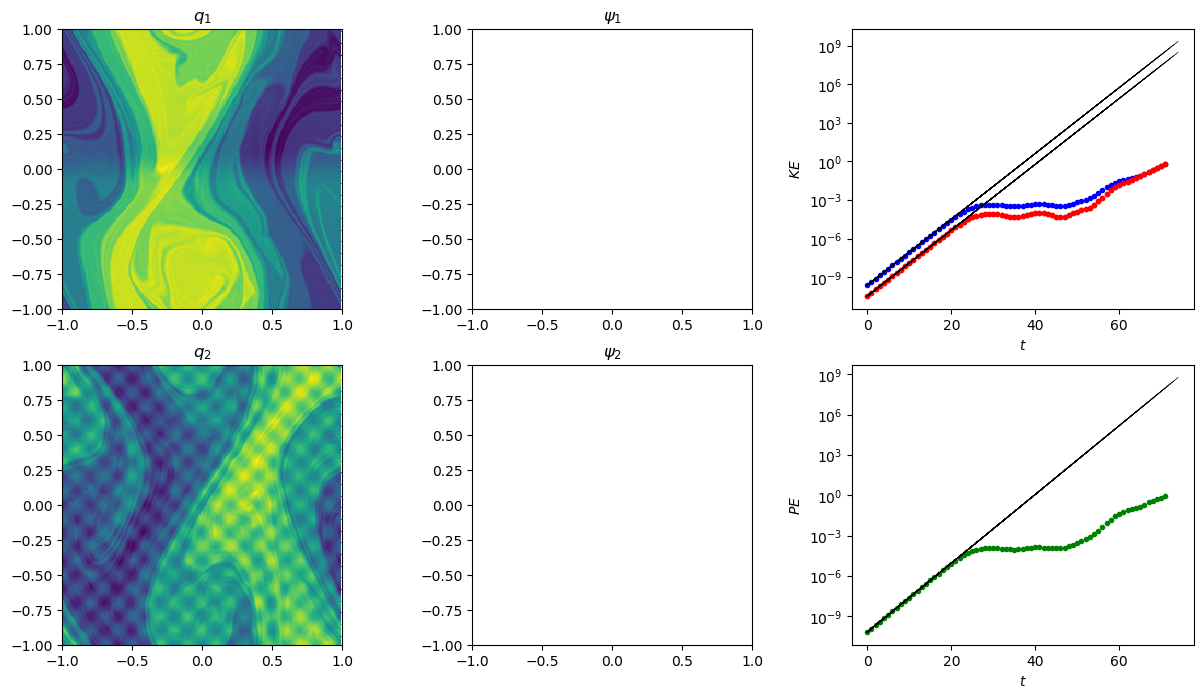

InterruptException: InterruptException:

In [22]:
fig, axs = subplots(ncols=3, nrows=2, figsize=(15, 8))
plot_output(prob, fig, axs)

# Step forward
startwalltime = time()

while cl.step < nsteps
    stepforward!(prob, diags, nsubs)

    # Message
    log = @sprintf("step: %04d, t: %d, KE1: %.4f, KE2: %.4f, PE: %.4f, τ: %.2f min", cl.step, cl.t, E.data[E.i][1][1], E.data[E.i][1][2], E.data[E.i][2][1], (time()-startwalltime)/60)

    println(log)

    plot_output(prob, fig, axs)
    sleep(0.001)
    IJulia.clear_output(true)
    display(fig)
end
println((time()-startwalltime))

plot_output(prob, fig, axs; drawcolorbar=false)


In [30]:
cl.t

74.45000000000789